# MNIST Classification with a CNN

## Contents
- <a href='#1.0'>1.0 Introduction and Setup<a>
    - <a href='#1.1'>1.1 Importing Dependencies<a>
    - <a href='#1.2'>1.2 Model Architecture<a>
    - <a href='#1.3'>1.3 Importing and Augmenting the Data<a>
- <a href='#2.0'>2.0 Training the Model<a>
    - <a href='#2.1'>2.1 Learning Rate Finder<a>

## <a id='1.0'>1.0 Introduction and Setup<a>

This is my implementation of a Convolutional Neural Network for handwritten digit recognition on the MNIST dataset using PyTorch.

In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### <a id='1.1'>1.1 Importing Dependencies<a>

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import style
from Trainer import trainer
import numpy as np
style.use('ggplot')

In [3]:
# Set device where our training will take place
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### <a id='1.2'>1.2 Model Architecture<a>

This Convolutional Neural Network will have three Convolutional blocks. Each block will perform a convolution operation for feature learning, dropout for regularization and batch normalization to help speed up the training process. Each block is activated using ReLU. After the Convolutional blocks, there will be two fully connected layers for classification. The final layer will have a logged softmax activation for prediction.

In [4]:
# Define our model
class ConvNet(nn.Module):
    def __init__(self, in_channel, out_channel=32, img_dim=7, num_classes=10):
        super(ConvNet, self).__init__()
        self.im_size = img_dim

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channel, 16, (5, 5))
        nn.init.kaiming_normal_(self.conv1.weight)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.batch1 = nn.BatchNorm2d(16)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(16, 32, (3, 3))
        nn.init.kaiming_normal_(self.conv2.weight)
        self.dropout2 = nn.Dropout2d(p=0.15)
        self.batch2 = nn.BatchNorm2d(32)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(32, out_channel, (1, 1))
        nn.init.kaiming_normal_(self.conv3.weight)
        self.dropout3 = nn.Dropout2d(p=0.1)
        self.batch3 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(3)

        # Fully Connected Layer
        self.fc1 = nn.Linear(out_channel * img_dim * img_dim, num_classes * 2)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(num_classes * 2, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # Conv Block 1
        out = self.conv1(x)
        out = self.dropout1(out)
        out = self.batch1(out).clamp(min=0)

        # Conv Block 2
        out = self.conv2(out)
        out = self.dropout2(out)
        out = self.batch2(out).clamp(min=0)

        # Conv Block 3
        out = self.conv3(out)
        out = self.dropout3(out)
        out = self.batch3(out).clamp(min=0)
        out = self.pool(out)

        # Flatten
        out = out.reshape(out.size(0), -1)
        # Fully Connected
        out = self.fc1(out).clamp(min=0)
        out = F.log_softmax(self.fc2(out))
        return out

### <a id='1.3'>1.3 Importing and Augmenting the Data<a>

PyTorch makes it easy to import the MNIST dataset, since it's so popular. With the torchvision library we are able to download/import datasets and apply data augmentation with ease.

The augmentation we'll apply to our training data involves applying random rotations to the left or right with a maximum rotation of 15 degrees. Our training data will also be shuffled randomly each epoch. In this code block we'll also set our batch size to 100 images.

In [5]:
# Perform some data augmentation
aug = transforms.Compose([transforms.RandomRotation(15),
                          transforms.ToTensor()])
batch_size = 100

Here is where we will import our training and testing data.

In [6]:
# download our MNIST data
# Augment our training set
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=aug,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor())

# Load our training set
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Load our Testing set
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## <a id='#2.0'>2.0 Training our model<a>
    
The techniques used for training this classifier currently are able to produce the state-of-the-art results.

In [7]:
# Load our model
model = ConvNet(in_channel=1).to(device)

# Define our Loss function and our Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# load the model into our trainer
learn = trainer(model, criterion, optimizer)

### <a id='2.1'>2.1 Learning Rate Finder<a>

One of the most underappreciated practices in Deep Learning is the use of a learning rate finder. By exponentially increasing the learning rate over the course of one epoch we can find the maximal learning rate that still converges to a minimum. To pick the learning rate, all we need to do is look at where the loss reaches a minimum and take a learning rate that is one order of magnitutde that is lower, this prevents our model from overshooting a local minimum during training.

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/1], Step [100/600], Loss: 1.9700
Epoch [1/1], Step [200/600], Loss: 0.8294
Epoch [1/1], Step [300/600], Loss: 0.3448
Epoch [1/1], Step [400/600], Loss: 0.1035
Epoch [1/1], Step [500/600], Loss: 1.2783
Epoch [1/1], Step [600/600], Loss: 2.4362


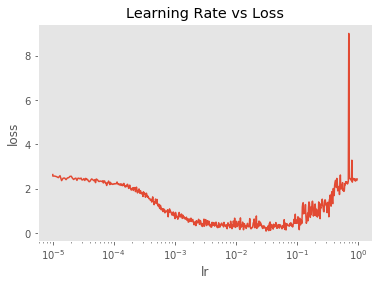

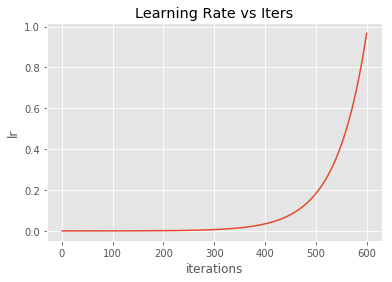

In [8]:
# Run the learning rate finder
learn.lr_find(train_loader)
# After this the parameters in our model will be all messed up

In [9]:
# Reset model and optimizer in our trainer
model = ConvNet(in_channel=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

learn = trainer(model, criterion, optimizer)

### <a id='2.2'> Training our Model<a>

Instead of using a normal training routine where our learning rate is constant, the method used here is called [Stochastic Gradient Descent with Restarts](https://arxiv.org/abs/1608.03983). We define a number of cycles which is used for training. A cycle is a round of training where our learning rate is bumped up to the max and is slowly annealed so that our model converges onto a minimum. The reason that we bump up our learning rate in such a way is because we want to search the optimization space and find a stable minimum. This is in hopes of improving how our model improves on new testing data and with it's ability to generalize. 

#################### EPOCH 1 ####################


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/24], Step [100/600], Loss: 0.6020
Epoch [1/24], Step [200/600], Loss: 0.3535
Epoch [1/24], Step [300/600], Loss: 0.2630
Epoch [1/24], Step [400/600], Loss: 0.1539
Epoch [1/24], Step [500/600], Loss: 0.2252
Epoch [1/24], Step [600/600], Loss: 0.1872
#################### EPOCH 2 ####################
Epoch [2/24], Step [100/600], Loss: 0.2081
Epoch [2/24], Step [200/600], Loss: 0.2164
Epoch [2/24], Step [300/600], Loss: 0.1125
Epoch [2/24], Step [400/600], Loss: 0.1044
Epoch [2/24], Step [500/600], Loss: 0.1631
Epoch [2/24], Step [600/600], Loss: 0.2759
#################### EPOCH 3 ####################
Epoch [3/24], Step [100/600], Loss: 0.1758
Epoch [3/24], Step [200/600], Loss: 0.1659
Epoch [3/24], Step [300/600], Loss: 0.0854
Epoch [3/24], Step [400/600], Loss: 0.2651
Epoch [3/24], Step [500/600], Loss: 0.0534
Epoch [3/24], Step [600/600], Loss: 0.0889
#################### EPOCH 4 ####################
Epoch [4/24], Step [100/600], Loss: 0.0279
Epoch [4/24], Step [200/600], Los

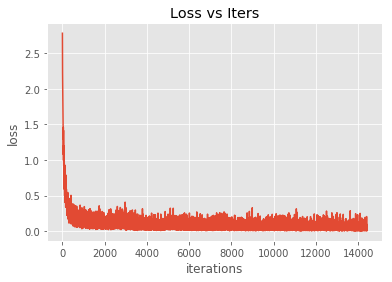

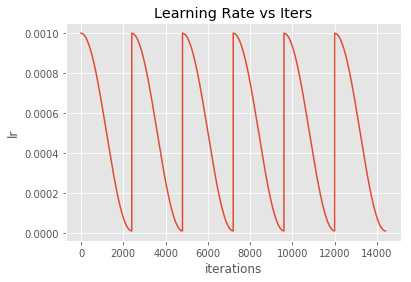

In [10]:
learn.SGDR(train_loader, cycles=6, cycle_len=4, snapshot=True)

In [11]:
learn.test(test_loader)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 99.06 %
Test Loss: 2.8181930626305984


In [14]:
learn.test(test_loader, snapshot=3)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 99.06 %
Test Loss: 2.930755730769306


In [13]:
torch.save(model.state_dict(), 'model.ckpt')